<a href="https://colab.research.google.com/github/amballa-mahesh/Deep_learning_facemask_detection/blob/main/Deep_learning_facemask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import tensorflow

In [5]:
os.getcwd()

'e:\\Vscode_files\\End_to_End_Ml_project_Facemask'

In [4]:
os.chdir('e:\\Vscode_files\\End_to_End_Ml_project_Facemask')

In [1]:
image_names = os.listdir('downloads/Images')

NameError: name 'os' is not defined

In [46]:
labels = []
for image in image_names:
  name = image.split('.')[0]
  if name == 'with_mask':
    labels.append('1')
  else:
    labels.append('0')

In [18]:
import pandas as pd
import numpy as np

In [47]:
df = pd.DataFrame({'file_name':image_names,'labels':labels})
df.shape

(1375, 2)

In [20]:
df.head()

,file_name,labels
0,without_mask. (1).jpg,0
1,without_mask. (10).jpg,0
2,without_mask. (100).jpg,0
3,without_mask. (101).jpg,0
4,without_mask. (102).jpg,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1375 non-null   object
 1   labels     1375 non-null   object
dtypes: object(2)
memory usage: 21.6+ KB


In [22]:
df['labels'].value_counts()

labels
1    690
0    685
Name: count, dtype: int64

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing.image import load_img

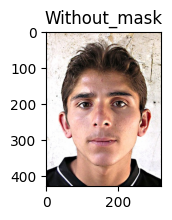

In [24]:
i = 3
image = load_img('downloads/Images/'+ str(df['file_name'][i]))
plt.figure(figsize = (4,2))
if df['labels'][i]=="0":
  title = 'Without_mask'
else:
  title = 'With_mask'
plt.title(title)
plt.imshow(image)
plt.show()

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_df,test_df = train_test_split(df,random_state = 123,test_size= 0.2,stratify = df['labels'])

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
train_data = ImageDataGenerator(rescale = 1./255,
                                rotation_range =20,
                                horizontal_flip= True,
                                vertical_flip = True)
test_data =ImageDataGenerator(rescale =1./255)

In [29]:
train_data_generator = train_data.flow_from_dataframe(dataframe = train_df,
                                                      directory='downloads/Images/',
                                                      target_size =(224,224),
                                                      x_col = 'file_name',
                                                      y_col = 'labels',
                                                      color_mode = 'rgb',
                                                      class_mode = 'binary',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      validate_filenames = True
                                                      )

Found 1100 validated image filenames belonging to 2 classes.


In [30]:
test_data_generator = test_data.flow_from_dataframe(dataframe = test_df,
                                                      directory='downloads/Images/',
                                                      target_size =(224,224),
                                                      x_col = 'file_name',
                                                      y_col = 'labels',
                                                      color_mode = 'rgb',
                                                      class_mode = 'binary',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      validate_filenames = True)

Found 275 validated image filenames belonging to 2 classes.


In [5]:
from tensorflow.keras import applications

In [7]:
base_model = tensorflow.keras.applications.MobileNetV2(weights = 'imagenet',
                                                       include_top = False,
                                                       input_shape = (224,224,3))
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [8]:
flatten_layer = tensorflow.keras.layers.Flatten()
output_layer  = tensorflow.keras.layers.Dense(1, activation = 'sigmoid')

In [9]:
final_model = tensorflow.keras.Sequential([base_model,flatten_layer,output_layer])

In [10]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1)                 62721     
                                                                 
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
mc = tensorflow.keras.callbacks.ModelCheckpoint(filepath = 'artifacts/best_model.h5',
                                                               monitor = 'val_loss',
                                                               mode = 'min',
                                                               save_best_only = True)
es= tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 mode='max',
                                                 patience=5,
                                                 restore_best_weights= True,
                                                 )

In [33]:
final_model.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy', 
                    metrics ='accuracy')

In [55]:
history = final_model.fit(train_data_generator,
                          steps_per_epoch =train_data_generator.samples//32,
                          validation_data = test_data_generator,
                          validation_steps = test_data_generator.samples//32,
                          epochs = 30,
                          callbacks = [mc,es])

Epoch 1/30
34/34 [==============================] - 60s 2s/step - loss: 0.0752 - accuracy: 0.9850 - val_loss: 0.0968 - val_accuracy: 0.9883
Epoch 2/30
34/34 [==============================] - 58s 2s/step - loss: 0.0597 - accuracy: 0.9925 - val_loss: 0.1502 - val_accuracy: 0.9766
Epoch 3/30
34/34 [==============================] - 51s 1s/step - loss: 0.0370 - accuracy: 0.9925 - val_loss: 0.0738 - val_accuracy: 0.9961
Epoch 4/30
34/34 [==============================] - 53s 2s/step - loss: 0.0441 - accuracy: 0.9944 - val_loss: 0.0555 - val_accuracy: 0.9922
Epoch 5/30
34/34 [==============================] - 50s 1s/step - loss: 0.0814 - accuracy: 0.9888 - val_loss: 0.1206 - val_accuracy: 0.9844
Epoch 6/30
34/34 [==============================] - 49s 1s/step - loss: 0.0158 - accuracy: 0.9963 - val_loss: 0.0474 - val_accuracy: 0.9883
Epoch 7/30
34/34 [==============================] - 50s 1s/step - loss: 0.0471 - accuracy: 0.9963 - val_loss: 0.1196 - val_accuracy: 0.9844
Epoch 8/30
34/34 [==

In [56]:
history.history

{'loss': [0.07518215477466583,
  0.059666939079761505,
  0.03695988655090332,
  0.04410636052489281,
  0.08141831308603287,
  0.015798091888427734,
  0.047056425362825394,
  0.03802046924829483],
 'accuracy': [0.9850187301635742,
  0.9925093650817871,
  0.9925093650817871,
  0.9943820238113403,
  0.9887640476226807,
  0.9962546825408936,
  0.9962546825408936,
  0.9943820238113403],
 'val_loss': [0.09677276015281677,
  0.15020687878131866,
  0.07376321405172348,
  0.05554018169641495,
  0.12055184692144394,
  0.0473848357796669,
  0.11960611492395401,
  0.0641903430223465],
 'val_accuracy': [0.98828125,
  0.9765625,
  0.99609375,
  0.9921875,
  0.984375,
  0.98828125,
  0.984375,
  0.9921875]}

In [57]:
print('Training Accuracy Score: ',np.mean(history.history['accuracy']).round(2))
print('Validation Accuracy Score: ',np.mean(history.history['val_accuracy']).round(2))
print('Training Loss: ',np.mean(history.history['loss']).round(2))
print('Validation Loss: ',np.mean(history.history['val_loss']).round(2))

Training Accuracy Score:  0.99
Validation Accuracy Score:  0.99
Training Loss:  0.05
Validation Loss:  0.09


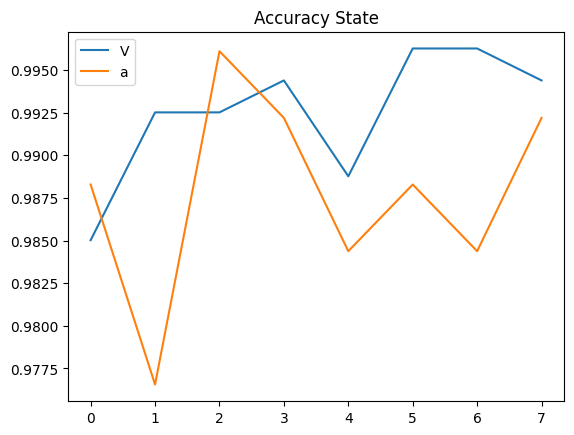

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend('Training Accuracy Score')
plt.legend('Validation Accuracy Score')
plt.title('Accuracy State')
plt.show()

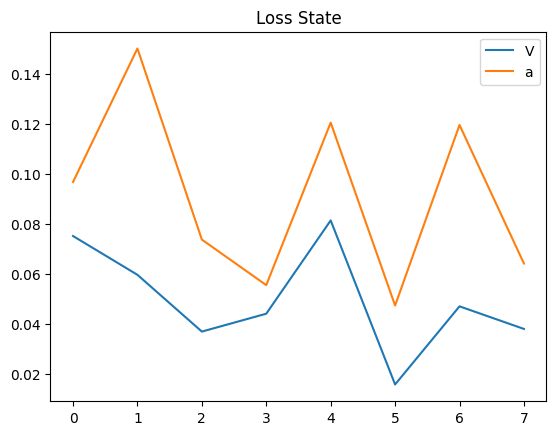

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend('Training Loss Score')
plt.legend('Validation Loss Score')
plt.title('Loss State')
plt.show()

In [60]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img,img_to_array
best_model = load_model("artifacts/best_model.h5")

In [61]:
def image_treat(image):
  image = img_to_array(image)
  image = image/255
  image_change = np.expand_dims(image,axis=0)
  return(image_change)

In [62]:
image_names = os.listdir('downloads/Images')
len(image_names)

1375

1/1 [==============================] - 0s 217ms/step


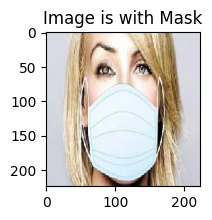

1/1 [==============================] - 0s 63ms/step


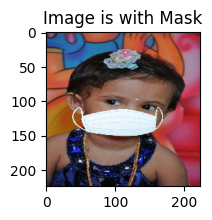

1/1 [==============================] - 0s 67ms/step


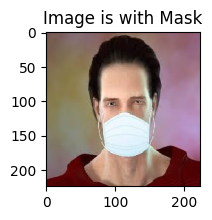

1/1 [==============================] - 0s 62ms/step


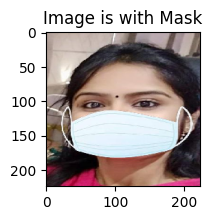

1/1 [==============================] - 0s 68ms/step


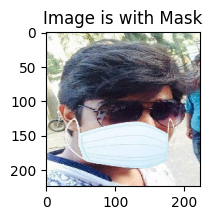

1/1 [==============================] - 0s 74ms/step


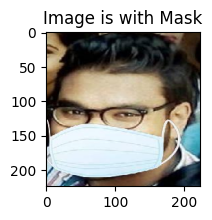

1/1 [==============================] - 0s 173ms/step


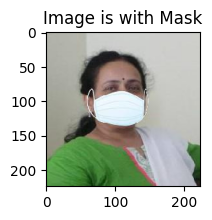

1/1 [==============================] - 0s 68ms/step


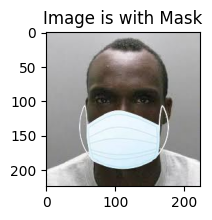

1/1 [==============================] - 0s 60ms/step


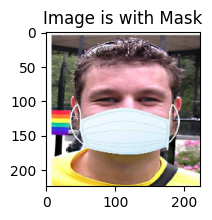

1/1 [==============================] - 0s 60ms/step


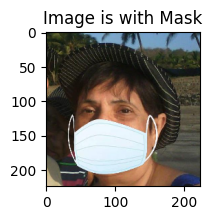

In [64]:
image_names = os.listdir('downloads/Images')
for i in range(1350,1360):
  image = load_img('downloads/Images/'+str(image_names[i]),target_size=(224,224)) 
  image_change = image_treat(image)
  pred = best_model.predict(image_change).round()
  predict_result=''
  if pred[0] == 1:
    predict_result = 'Image is with Mask'
  else:
    predict_result = 'Image is not with Mask'
  plt.figure(figsize = (2,2))
  plt.imshow(image)
  plt.title(predict_result)
  plt.show()